In [1]:
# depedencies
import getpass
from topolib.subsetDat import subsetBBox;
from topolib import IceSat2Data;
import glob
import rasterio
from topolib import gda_lib;
from topolib import dwnldArctic
import numpy as np
import geopandas as gpd
from multiprocessing import Pool

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/srv/conda/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# inputs
# if want to explcitly define bounding box, raster = None
datafolder = '/home/jovyan/data/'
datafolderOut = '/home/jovyan/data/Arctic/'

#if have raster define raster, if not, use None
raster = datafolder+'Tuolumne_snow-off_ASO.tif'
# raster = None
rasterBnd = 1

if rasterBnd == None:
    # Area of interest
    boundaries = {
        'LowerLeft_Lon': '-138.9',
        'LowerLeft_Lat': '60.7',
        'UpperRight_Lon': '-138.8',
        'UpperRight_Lat': '60.8',
    }

# Specify the variables of interest
LIce_var = ['atl06_quality_summary','delta_time','h_li','hli_sigma',\
           'latitude','longitude','segment_id','sigma_geo_h']
variables = {
    'beams': [
        '/land_ice_segments/'+LIce_var[0],
        '/land_ice_segments/'+LIce_var[1],
        '/land_ice_segments/'+LIce_var[2],
        '/land_ice_segments/'+LIce_var[3],
        '/land_ice_segments/'+LIce_var[4],
        '/land_ice_segments/'+LIce_var[5],
        '/land_ice_segments/'+LIce_var[6],
        '/land_ice_segments/'+LIce_var[7],
        '/ancillary_data/atlas_sdp_gps_epoch',
    ],
    'other': [
        '/orbit_info/cycle_number',
        '/orbit_info/rgt',
        '/orbit_info/orbit_number',
    ]
}

# Custom time range of interest
# define full_per = 1
full_per = 1
time_range = {
        'start_date': '2018-10-01',
        'end_date': '2019-01-01'
}

# Enter your Earthdata Login user name
user_id = 'jpflug'
# Enter your email address associated with your Earthdata Login account
email = ''

In [3]:
def fetch_arcticDEM(bbox,dest_folder):
    
    #make a directory for ArcticDEM files
    %mkdir ArcticDEM
    %cd ArcticDEM/

    #download the Arctic DEM tiles from PGC
    !wget -nc http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Tile_Index_Rel7.zip
    !unzip ArcticDEM_Tile_Index_Rel7.zip

    #define the bounding box that you want to download DEMs for
    bbox_w = bbox[0]
    bbox_s = bbox[1]
    bbox_e = bbox[2]
    bbox_n = bbox[3]
    
    #read in tiles from the ArcticDEM
    tiles = gpd.read_file("ArcticDEM_Tile_Index_Rel7.shp")
    tiles = tiles.to_crs({'init':'epsg:4326'}) #transform to WGS84

    #intersect the 
    intersection = tiles.cx[bbox_w:bbox_e,bbox_s:bbox_n]

    download_tiles_ids = intersection['tile'].values
    dest_folder = [dest_folder]*len(download_tiles_ids)
    input_var = list(zip(dest_folder,download_tiles_ids))
    
    with Pool(10) as p:
        p.map(dwnldArctic.arcticDEM_download,[tile_id for tile_id in input_var])

In [4]:
# load DEM
if raster == None:
    bbox = [np.float(x) for x in list(boundaries.values())]
    fetch_arcticDEM(bbox,datafolderOut)
else:   
    ds = rasterio.open(raster)
    dem = ds.read(1)
    dem = np.ma.masked_equal(dem,gda_lib.get_ndv(ds))
    xmin,ymin,xmax,ymax = ds.bounds
    ds.crs

In [5]:
? dwnldArctic.arcticDEM_download

Signature:  dwnldArctic.arcticDEM_download(input_v)
Docstring: <no docstring>
File:      ~/topohack/topolib/dwnldArctic.py
Type:      function


In [6]:
# preprocessing
if rasterBnd != None:
    [L,B,R,T] = subsetBBox(raster,ds.crs,'epsg:4326') # now read projection from DEM, convert to WGS84
    #[L,B,R,T] = subsetBBox(raster,'epsg:32611','epsg:4326')
    # Area of interest
    boundaries = {
        'LowerLeft_Lon': L,
        'LowerLeft_Lat': B,
        'UpperRight_Lon': R,
        'UpperRight_Lat': T,
    }
L,B,R,T

(-119.78855601487822, 37.72826260439459, -119.2000171661589, 38.19435356884997)

In [7]:
# Earthdata Login credentials
password = getpass.getpass('Earthdata Login password: ')

# Setup a search session
search = IceSat2Data(user_id, password, variables=variables)

Earthdata Login password:  ········


In [8]:
# Show available variables
search.show_variables()

# Show available formats
search.show_formats()

['/ancillary_data',
 '/ancillary_data/atlas_sdp_gps_epoch',
 '/ancillary_data/control',
 '/ancillary_data/data_end_utc',
 '/ancillary_data/data_start_utc',
 '/ancillary_data/end_cycle',
 '/ancillary_data/end_delta_time',
 '/ancillary_data/end_geoseg',
 '/ancillary_data/end_gpssow',
 '/ancillary_data/end_gpsweek',
 '/ancillary_data/end_orbit',
 '/ancillary_data/end_region',
 '/ancillary_data/end_rgt',
 '/ancillary_data/granule_end_utc',
 '/ancillary_data/granule_start_utc',
 '/ancillary_data/qa_at_interval',
 '/ancillary_data/release',
 '/ancillary_data/start_cycle',
 '/ancillary_data/start_delta_time',
 '/ancillary_data/start_geoseg',
 '/ancillary_data/start_gpssow',
 '/ancillary_data/start_gpsweek',
 '/ancillary_data/start_orbit',
 '/ancillary_data/start_region',
 '/ancillary_data/start_rgt',
 '/ancillary_data/version',
 '/ancillary_data/land_ice',
 '/ancillary_data/land_ice/dt_hist',
 '/ancillary_data/land_ice/fit_maxiter',
 '/ancillary_data/land_ice/fpb_maxiter',
 '/ancillary_data/l

In [9]:
# Search for granules in bounding box without download through all datasets
search.search_granules(bounding_box=boundaries)

# Search for granules in bounding box without download for specific time range
search.search_granules(bounding_box=boundaries, time_range=time_range)

Number of granules:
    8
Average size of granules in MB:
    22.242888808249997
Total size in MB:
    177.943110466
Number of granules:
    6
Average size of granules in MB:
    20.415529727933333
Total size in MB:
    122.4931783676


6

In [10]:
# NOTE: file paths have to be explicitly defined 
# BEFORE submitting 

params = {}
if full_per:
    params['time_range'] = time_range

# Submit a download order to NSIDC with no time restriction
search.order_data(
    email,
    datafolderOut,
    boundaries,
    **params
)

Number of granules:
    6
Average size of granules in MB:
    20.415529727933333
Total size in MB:
    122.4931783676
Order:  1
Request HTTP response:  201
order ID:  5000000320509
Data request  1  is submitting...
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  complete_with_errors
error messages:
['161151127:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 '161176080:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 '161209518:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 '161210744:NoMatchingData - No data found that matched subset constraints. '
 'Exit code 3.',
 'PT1.979S',
 'ICESAT2']
Beginning download of zipped output...
Data request 1 is complete.


In [11]:
# glob to list of files
ATL06_list = glob.glob(datafolderOut+'*.h5')

In [12]:
# del ATL06_list[2] # x.to_crs crashed on this file
# ATL06_list

In [13]:
# read hdf5 into a geodataframe
dataset_dict={'land_ice_segments':LIce_var, 'land_ice_segments/ground_track':['x_atc']}

In [14]:
## add recursively
ATL06_gdf_list = [gda_lib.ATL06_2_gdf(x,dataset_dict) for x in ATL06_list]
ATL06_gdf_list = [x.to_crs(ds.crs) for x in ATL06_gdf_list]
ATL06_gdf_list;
big_gdf = gda_lib.concat_gdf(ATL06_gdf_list)

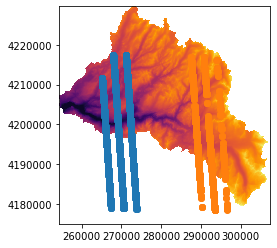

In [15]:
# seems to have removed some IceSAT2 lines that are in Profiling_struggle.ipynb
%matplotlib inline
import matplotlib.pyplot as plt 
fig,ax = plt.subplots()
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
#ATL06_gdf_list[1].plot(ax=ax)
for gdf in ATL06_gdf_list:
    gdf.plot(ax=ax)

In [16]:
df1,df2,df3,df4,df5,df6 = [x for x_,x in ATL06_gdf_list[1].groupby(ATL06_gdf_list[1]['p_b'])] #pick 1 ATL06 and seperate it into 6
df_list = [df1,df2,df3,df4,df5,df6]

-18.504121913466342 252.78507603111265 -0.5508148715942514
0.38108416685124036 2.254291795882281 0.0394012211571492
54.621960826755796 210.40869082124325 1.5931456372062454
-2.1071135753721704 65.55715977971201 -0.09240064478711804
-573.6537426757812 988.188457663341 -17.52319653474577
-252.99052385602678 583.4285728236908 -7.37397841918064


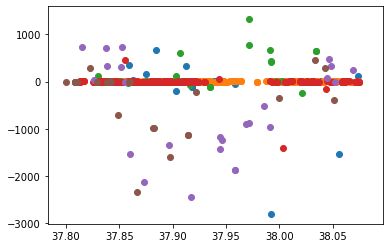

In [17]:
df_test_big = gda_lib.buffer_sampler(ds,big_gdf,20,ret_gdf=True)
df_test_big['snow_on_off'] = df_test_big['h_li']-df_test_big['med']

fig,ax = plt.subplots()
for gdf in df_list:
    df_test = gda_lib.buffer_sampler(ds,gdf,20,ret_gdf=True)
    df_test['snow_on_off'] = df_test['h_li']-df_test['med']
    ax.scatter(df_test['latitude'],df_test['snow_on_off'])
    print(df_test['snow_on_off'].mean(),df_test['snow_on_off'].std(),100*df_test['snow_on_off'].mean()/(df_test['h_li'].max()-df_test['h_li'].min()))
# df_test['snow_on_off'].hist(bins=30)
# ax.scatter(df_test['latitude'],df_test['snow_on_off'])

big_gdf['diff'] = df_test_big['snow_on_off']

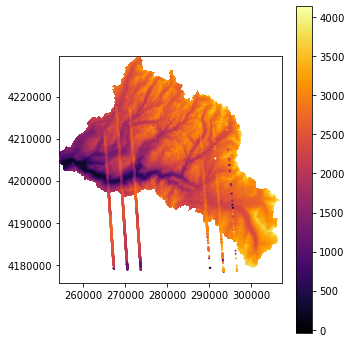

In [18]:
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
big_gdf.plot('h_li',legend=True,ax=ax,cmap='inferno',s=1)

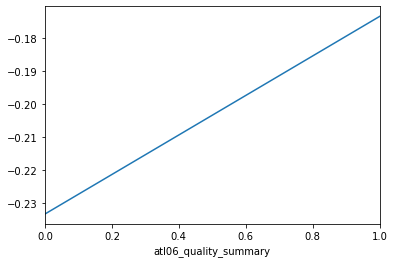

In [19]:
big_gdf.groupby('atl06_quality_summary').median()['diff'].plot()

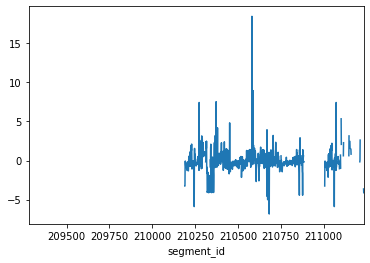

In [20]:
big_gdf.groupby('segment_id').median()['diff'].plot()

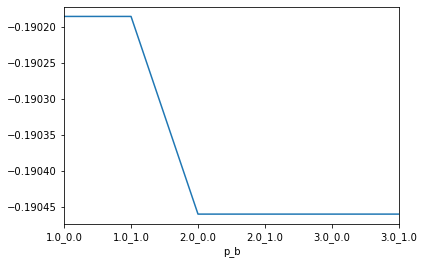

In [21]:
big_gdf.groupby('p_b').median()['diff'].plot()

In [22]:
!gdaldem slope $raster '/home/jovyan/data/slope.tif'
!gdaldem aspect $raster '/home/jovyan/data/aspect.tif'

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [23]:
ds2 = rasterio.open('/home/jovyan/data/slope.tif')
slp = ds2.read(1)
slp = np.ma.masked_equal(slp,gda_lib.get_ndv(ds2))
xmin,ymin,xmax,ymax = ds2.bounds
ds2.crs

CRS.from_epsg(32611)

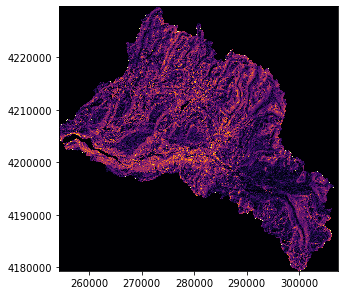

In [24]:
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(slp,cmap='inferno',extent=[xmin,xmax,ymin,ymax])

In [25]:
df_test_big_slp = gda_lib.buffer_sampler(ds2,big_gdf,20,ret_gdf=True)
good_idx = df_test_big['atl06_quality_summary']==0
df_test_big = df_test_big.loc[good_idx]

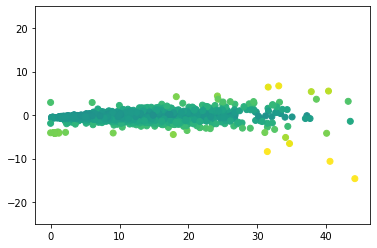

In [31]:
df_test_big_slp = df_test_big_slp.loc[good_idx]
fig,ax = plt.subplots()
ax.scatter(df_test_big_slp['med'],df_test_big['snow_on_off'],\
          c=abs(df_test_big['snow_on_off']),vmin=-7,vmax=7)
plt.ylim(-25,25)
#     df_test = gda_lib.buffer_sampler(ds,gdf,20,ret_gdf=True)
# df_test['snow_on_off'] = df_test['h_li']-df_test['med']
#     ax.scatter(df_test['latitude'],df_test['snow_on_off'])

In [32]:
ds3 = rasterio.open('/home/jovyan/data/aspect.tif')
asp = ds3.read(1)
asp = np.ma.masked_equal(asp,gda_lib.get_ndv(ds3))
xmin,ymin,xmax,ymax = ds3.bounds
ds3.crs

CRS.from_epsg(32611)

In [33]:
df_test_big_asp = gda_lib.buffer_sampler(ds3,big_gdf,20,ret_gdf=True)

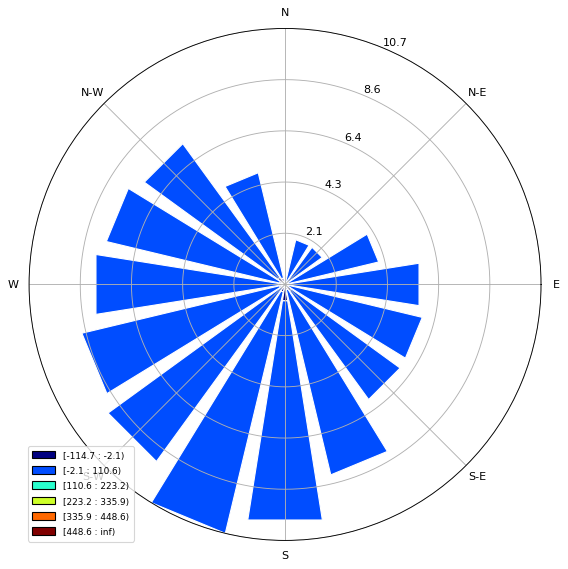

In [34]:
from windrose import WindroseAxes
import matplotlib.cm as cm
df_test_big_asp = df_test_big_asp.loc[good_idx]

ax = WindroseAxes.from_ax()
ax.bar(df_test_big_asp['med'],\
       df_test_big['snow_on_off'], normed=True,\
       opening=0.8, edgecolor='white');
ax.set_legend()